### Import annotations created using a pixel classifier in QuPath

### Use this to Calculate distance of each cell to the COVID infected area


Workflow

- Import QuPath annotations
- Convert to Shapely and save as geopandas dataframe
- Read resegmented data: cellxgene matrices, cell metadata, manifest file with pixel to micron conversion
- Apply this px to micron conversion to qupath outline to transform from px to micron space
- Create anndata object with cell xg ene matrix, metadata and tissue/covid outlines
- Calculate distance to nearest covid area for each cell and save it in the anndata
- Save the anndata objects for downstream analysis

In [ ]:
import pandas as pd 
import os 
import anndata as ad
import numpy as np
import json 
import shapely
import shapely.geometry as sg
import geopandas as gpd
import matplotlib.pyplot as plt
import scanpy as sc 


#get geojson files in a directory into a list
#for each files: Tissue mask and covid infected region determined using a pixel classifier
geojson_dir = "./qupath_outlines/"
geojson_files = os.listdir(geojson_dir)
geojson_region_files = [os.path.join(geojson_dir,file) for file in geojson_files if file.endswith(".geojson")] #and 'tissue'   in file

In [4]:
#Read all geojson file and convert to geopandas dataframe, where an extra colum filename is added to store the first 4 characters of filename
gdfs = []
for file in geojson_region_files:
    gdf = gpd.read_file(file)
    gdf['filename'] = file.split("\\")[-1][:7]
    #print(file.split("/")[-1][:4])
    gdfs.append(gdf)

#concatenate all geopandas dataframes into a single dataframe
gdf_all = pd.concat(gdfs, ignore_index=True)
#create a type column where type is the value of 'name' in dictionary within classificatio' column
gdf_all['annot_type'] = gdf_all['classification'].apply(lambda x: x['name'])
#rename str Region* to tissue_analysis_area in column type
gdf_all['annot_type'] = gdf_all['annot_type'].str.replace('Region*', 'tissue_analysis_area')
#split geometry multipolygon into single polygons
#gdf_exp = gdf_all.explode(index_parts=False).reset_index(drop=True)
#Save as multipolygon
gdf_all[['filename','geometry','annot_type']].to_csv("all_annotations.csv", index=False)

gdf_all

,id,objectType,classification,isLocked,geometry,filename,annot_type
0,70d5aa84-3d0f-48f2-b327-0e569fe58fd2,annotation,"{'name': 'covid_area', 'color': [47, 243, 197]}",True,"MULTIPOLYGON (((800.00000 22504.00000, 800.000...",region1,covid_area
1,cbcc8632-a590-481e-8916-b3c53190f216,annotation,"{'name': 'Region*', 'color': [0, 0, 180]}",True,"POLYGON ((32566.62000 564.00000, 32545.55000 5...",region1,tissue_analysis_area
2,79f39e15-310d-4810-bd80-abcf53cc90d1,annotation,"{'name': 'covid_area', 'color': [47, 243, 197]}",True,"MULTIPOLYGON (((904.00000 11688.00000, 904.000...",region2,covid_area
3,66d73aee-1bb4-411d-9660-3100771f9f92,annotation,"{'name': 'Region*', 'color': [0, 0, 180]}",NaN,"POLYGON ((17199.87000 500.00000, 17151.34000 5...",region2,tissue_analysis_area
4,2db5b57b-16a8-4263-9221-b09f3ed669b5,annotation,"{'name': 'covid_area', 'color': [47, 243, 197]}",True,"MULTIPOLYGON (((500.00000 14360.00000, 500.000...",region3,covid_area
5,e563503f-1bbc-47f4-aabe-486ade7db904,annotation,"{'name': 'Region*', 'color': [0, 0, 180]}",NaN,"POLYGON ((26308.08000 500.00000, 26293.79000 5...",region3,tissue_analysis_area


Read the cell by gene matrices, metadata, and MERSCOPE manifest files

Need MERSCOPE resegmented data here from the nextflow pipeline

In [ ]:
import os 
parent_dir = "./finalResults/" #directory with the nextflow outputs after resegmentation

region_0 = "Bader_SARS_region0/VPT_NextFlow/finalFiles/"
region_1 = "Bader_SARS_region1/VPT_NextFlow/finalFiles/"
region_2 = "Bader_SARS_region2/VPT_NextFlow/finalFiles/"
region_3 = "Bader_SARS_region3/VPT_NextFlow/finalFiles/"

region_0_path = os.path.join(parent_dir, region_0)
region_1_path = os.path.join(parent_dir, region_1)
region_2_path = os.path.join(parent_dir, region_2)
region_3_path = os.path.join(parent_dir, region_3)

files = ["cell_by_gene_repartitioned.csv","cell_metadata_resegmented.csv"]

#manifest and micron_to_mosaic_pixel_transform.csv files
region_0_json_dir = parent_dir+"/Bader_SARS_region0/202409301143_20240930G000403Batch6_VMSC04501_region_0/pictures/"
region_1_json_dir = parent_dir+"/Bader_SARS_region1/202409301143_20240930G000403Batch6_VMSC04501_region_1/pictures/"
region_2_json_dir = parent_dir+"/Bader_SARS_region2/202409301143_20240930G000403Batch6_VMSC04501_region_2/pictures/"
region_3_json_dir = parent_dir+"/Bader_SARS_region3/202409301143_20240930G000403Batch6_VMSC04501_region_3/pictures/"
json_files = ["manifest.json","micron_to_mosaic_pixel_transform.csv"]

region_0_files = [os.path.join(region_0_path, file) for file in files]
region_1_files = [os.path.join(region_1_path, file) for file in files]
region_2_files = [os.path.join(region_2_path, file) for file in files]
region_3_files = [os.path.join(region_3_path, file) for file in files]

#add manifest.json and micron_to_mosaic_pixel_transform.csv to the list of files for each region
region_0_files += [os.path.join(region_0_json_dir, file) for file in json_files]
region_1_files += [os.path.join(region_1_json_dir, file) for file in json_files]
region_2_files += [os.path.join(region_2_json_dir, file) for file in json_files]
region_3_files += [os.path.join(region_3_json_dir, file) for file in json_files]


#assert files exist
for file in region_0_files + region_1_files + region_2_files+ region_3_files:
    assert os.path.exists(file), f"{file} does not exist"
region_0_files

For MERSCOPE data, the cell coordinates are in micron space. This is also in the coordinate space of each tissue. 

The manifest.json file contains the information required to convert from pixel space to micron space. 

This allows us to convert the QuPath outlines from pixel to micron space coordinates

We then create anndata object for each region with all the required data

In [6]:

#Functions for converting px to micron space
def convert_px_micron_space_x(x,microns_per_pixel,bbox_microns):
    px = round((x*microns_per_pixel)+round(bbox_microns[0]))
    return px

def convert_px_micron_space_y(y,microns_per_pixel,bbox_microns):
    px = round((y*microns_per_pixel)+round(bbox_microns[1]))
    return px

def convert_px_micron_space(geom, microns_per_pixel, bbox_microns):
    """
    Convert a Shapely geometry from pixel space to microns space.
    If its multi polygon, convert each polygon in the multipolygon
    to micron space.
    """
    if geom.geom_type == 'MultiPolygon':
        # Transform each polygon in the MultiPolygon
        transformed_polygons = [
            sg.Polygon(
                np.array([
                    (convert_px_micron_space_x(x, microns_per_pixel, bbox_microns),
                     convert_px_micron_space_y(y, microns_per_pixel, bbox_microns))
                    for x, y in np.array(polygon.exterior.coords)
                ])
            )
            for polygon in geom.geoms
        ]
        return sg.MultiPolygon(transformed_polygons)
    elif geom.geom_type == 'Polygon':
        coords = np.array(geom.exterior.coords)
        coords[:, 0] = np.array([convert_px_micron_space_x(x, microns_per_pixel, bbox_microns) for x in coords[:, 0]])
        coords[:, 1] = np.array([convert_px_micron_space_y(y, microns_per_pixel, bbox_microns) for y in coords[:, 1]])
        return sg.Polygon(coords)
    else:
        raise ValueError(f"Unsupported geometry type: {geom.geom_type}")

def get_bbox_micron_per_pixel(manifest_path):
    with open(manifest_path, 'r') as f:
        manifest = json.load(f)
    #Read properties from the manifest files
    bbox_microns = manifest['bbox_microns']
    microns_per_pixel = manifest['microns_per_pixel']
    return bbox_microns, microns_per_pixel

#Create anndata objects with cell by gene and cell metadata

def create_adata_region(region_files,gdf,region_name):
    print(f"Creating anndata object for {region_name}")
    #Read cell by gene and cell metadata files
    cell_by_gene = pd.read_csv(region_files[0], index_col=0)
    cell_by_metadata = pd.read_csv(region_files[1], index_col=0)
    #Read manifest and micron_to_mosaic_pixel_transform.csv files
    manifest_path = region_files[2]
    affine_trans_path = region_files[3]
    bbox_microns, microns_per_pixel = get_bbox_micron_per_pixel(manifest_path) 

    #Create anndata object
    adata = ad.AnnData(X=cell_by_gene.values, obs=cell_by_metadata, var=cell_by_gene.columns.values)
    #rename var column
    adata.var.rename(columns={0: "gene_names"}, inplace=True)
    x_coord, y_coord = cell_by_metadata.center_x, cell_by_metadata.center_y
    coord2d=np.column_stack((x_coord, y_coord))
    #add spatial to obsm (default for scanpy and squidpy)
    adata.obsm['spatial'] = coord2d
    ##add spatial to uns as well
    #adata.uns['spatial'] = coord2d
    region_df = gdf[gdf['filename'] == region_name]
    covid_area = region_df[region_df['annot_type'] == 'covid_area'][['geometry','filename']]
    tissue_analysis_area = region_df[region_df['annot_type'] == 'tissue_analysis_area'][['geometry','filename']]
    #convert from px to micron space
    covid_area['geometry'] = covid_area['geometry'].apply(lambda x: convert_px_micron_space(x, microns_per_pixel, bbox_microns))
    tissue_analysis_area['geometry'] = tissue_analysis_area['geometry'].apply(lambda x: convert_px_micron_space(x, microns_per_pixel, bbox_microns))
    adata.uns['covid_area'] = covid_area
    adata.uns['tissue_analysis_area'] = tissue_analysis_area
    return adata

adata_region_0 = create_adata_region(region_0_files, gdf_all, 'region0')
adata_region_1 = create_adata_region(region_1_files, gdf_all, 'region1')
adata_region_2 = create_adata_region(region_2_files, gdf_all, 'region2')
adata_region_3 = create_adata_region(region_3_files, gdf_all, 'region3')



Creating anndata object for region0


c:\Users\Public\conda_envs\data_analysis\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Creating anndata object for region1


c:\Users\Public\conda_envs\data_analysis\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Creating anndata object for region2


c:\Users\Public\conda_envs\data_analysis\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Creating anndata object for region3


c:\Users\Public\conda_envs\data_analysis\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Verify that the tissue outlines, covid area and cell coordinates overlay on top of each other

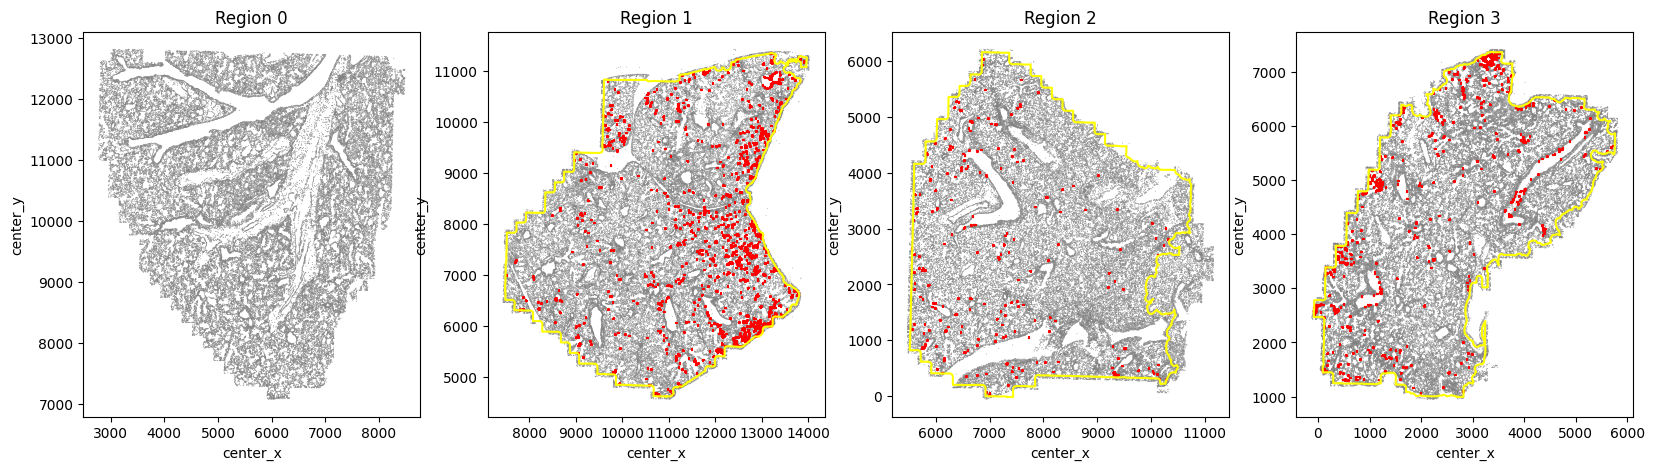

In [ ]:

def plot_exterior_interior(gdf,ax,colour='yellow'):
    """
    Plot the exterior and interior of polygons in a GeoDataFrame.
    Interiors are the holes in the polygons.
    """
    for poly in gdf['geometry']:
        x, y = poly.exterior.xy
        ax.plot(x, y, color=colour)
        
        # Plot the interiors (holes) if they exist
        interior_polys = [i for i in poly.interiors]
        if len(interior_polys) > 0:
            for interior_poly in interior_polys:
                x, y = interior_poly.xy
                ax.plot(x, y, color=colour)
    return None

def plot_covid_area(adata_region,ax,title):#, annot_type='covid_area'
    """
    Plot the covid area and tissue outline for a given region.
    """
    covid_region = adata_region.uns['covid_area']['geometry']
    tissue_outline = adata_region.uns['tissue_analysis_area']['geometry']

    gdf = gpd.GeoDataFrame(geometry=covid_region)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)

    # Create a GeoDataFrame for the tissue outline
    gdf_tissue = gpd.GeoDataFrame(geometry=tissue_outline)
    gdf_tissue = gdf_tissue.explode(index_parts=False).reset_index(drop=True)
    
    # Create a figure and axis
    #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Plot scatter using scanpy
    sc.pl.scatter(adata_region, x='center_x', y='center_y', ax=ax, show=False,title=title)
    
    # Add outlines from covid_annotation to the same plot
    plot_exterior_interior(gdf, ax,colour='red')
    plot_exterior_interior(gdf_tissue, ax,colour='yellow')



#plot_covid_area(adata_region_2)
#plot for each region 
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
plot_covid_area(adata_region_0,ax[0],title='Region 0')
plot_covid_area(adata_region_1,ax[1],title='Region 1')
plot_covid_area(adata_region_2,ax[2],title='Region 2')
plot_covid_area(adata_region_3,ax[3],title='Region 3')
plt.show()

#create save dir
#save_dir = os.path.join(parent_dir, "anndata_files")
#save figure 
#os.makedirs(save_dir, exist_ok=True)
#fig.savefig(os.path.join(save_dir, "tissue_covid_overlay.png"), dpi=300, bbox_inches='tight')

Remove cells that are outside the tissue analysis area

In [8]:
def subset_adata_to_tissue_area(adata):
    #create a mask for the points in the tissue area
    gdf_a = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1]),
        crs=None
    )
    mask = adata.uns['tissue_analysis_area'].geometry.values[0].contains(gdf_a).geometry
    #shape before mask
    print(f"Shape before mask: {adata.shape}")
    #use boolean mask to subset n_obs in adata
    adata_mask = adata[mask]
    #shape after mask
    print(f"Shape after mask: {adata_mask.shape}")
    return adata_mask


adata_region_1 = subset_adata_to_tissue_area(adata_region_1)
adata_region_2 = subset_adata_to_tissue_area(adata_region_2)
adata_region_3 = subset_adata_to_tissue_area(adata_region_3)

Shape before mask: (101037, 315)
Shape after mask: (95041, 315)
Shape before mask: (89199, 315)
Shape after mask: (79640, 315)
Shape before mask: (94435, 315)
Shape after mask: (86824, 315)


Compute the distances of cells from COVID area

Uses spatial indexing to make it faster

In [9]:
from tqdm import tqdm 

def compute_distances_sindex(adata_orig,annot_type='covid_area'):
    adata = adata_orig.copy()
    # Convert fibrosis polygons to GeoDataFrame
    covid_gdf = gpd.GeoDataFrame(geometry=adata.uns[annot_type]['geometry'])
    # Build spatial index (sindex)
    sindex = covid_gdf.sindex
    
    # Extract spatial coordinates
    #cell_coords = adata.obs[['center_x', 'center_y']].values
    cell_coords = adata.obsm["spatial"]
    
    # Initialize distance array
    distances = np.full(len(cell_coords), np.inf)

    for i, (x, y) in tqdm(enumerate(cell_coords)):
        cell_point = sg.Point(x, y)

        # Query nearby polygons using spatial index
        possible_matches_index = list(sindex.intersection(cell_point.bounds))
        candidate_polygons = covid_gdf.iloc[possible_matches_index].geometry

        # If no candidates found, use all polygons
        if candidate_polygons.empty:
            candidate_polygons = covid_gdf.geometry  # Use all polygons to find nearest

        min_distance = np.inf  # Track minimum distance for the cell
        
        for poly in candidate_polygons:
            if poly.contains(cell_point):
                # Inside: Negative distance to boundary
                distance = -cell_point.distance(poly.boundary)
            else:
                # Outside: Positive distance to nearest edge
                distance = cell_point.distance(poly.boundary)
            
            min_distance = min(min_distance, distance)
        
        distances[i] = min_distance  # Always has a valid nearest distance
    
    # Store distances in adata.obs
    if annot_type == 'covid_area':
        adata.obs["distance_to_nearest_covid"] = distances
    return adata

Calculate distances for each region. Note region 0 does not have any covid infection, hence not included

In [10]:
%%time
adata_region_1_distance = compute_distances_sindex(adata_region_1,annot_type='covid_area')

95041it [02:11, 723.78it/s]

CPU times: total: 2min 11s
Wall time: 2min 11s


In [11]:
%%time
adata_region_2_distance = compute_distances_sindex(adata_region_2,annot_type='covid_area')

79640it [01:00, 1313.51it/s]

CPU times: total: 1min
Wall time: 1min


In [12]:
%%time
adata_region_3_distance = compute_distances_sindex(adata_region_3,annot_type='covid_area')

86824it [01:28, 979.78it/s] 

CPU times: total: 1min 29s
Wall time: 1min 28s


In [13]:
adata_region_1_distance.obs.head()

,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,distance_to_nearest_covid
EntityID,,,,,,,,,,,,,
2213990800008100046,NaN,1672.992085,9884.025498,4842.232525,9874.050441,4836.791035,9892.385646,4848.130445,1.629714,NaN,0.309932,0.979337,56.382122
2213990800008100047,NaN,1294.942827,9944.302060,4843.945791,9935.719347,4837.590887,9952.404944,4849.472238,1.789447,NaN,0.388568,0.890101,1.054209
2213990800009100061,NaN,1886.023187,10234.754098,4835.121003,10227.895423,4825.587430,10240.912210,4845.609433,1.462410,NaN,0.292721,0.966115,279.051643
2213990800009100066,NaN,1142.108580,10198.362491,4837.678827,10192.016297,4829.295384,10203.004565,4844.568927,1.452188,NaN,0.389481,0.940950,242.584771
2213990800009100067,NaN,1244.153284,10206.703411,4843.171464,10202.153150,4834.005207,10211.710514,4851.879785,1.901486,NaN,0.375975,0.956775,250.412274


Show distance to neareste covid area. 

Using inverse colormap to highlight hotspots

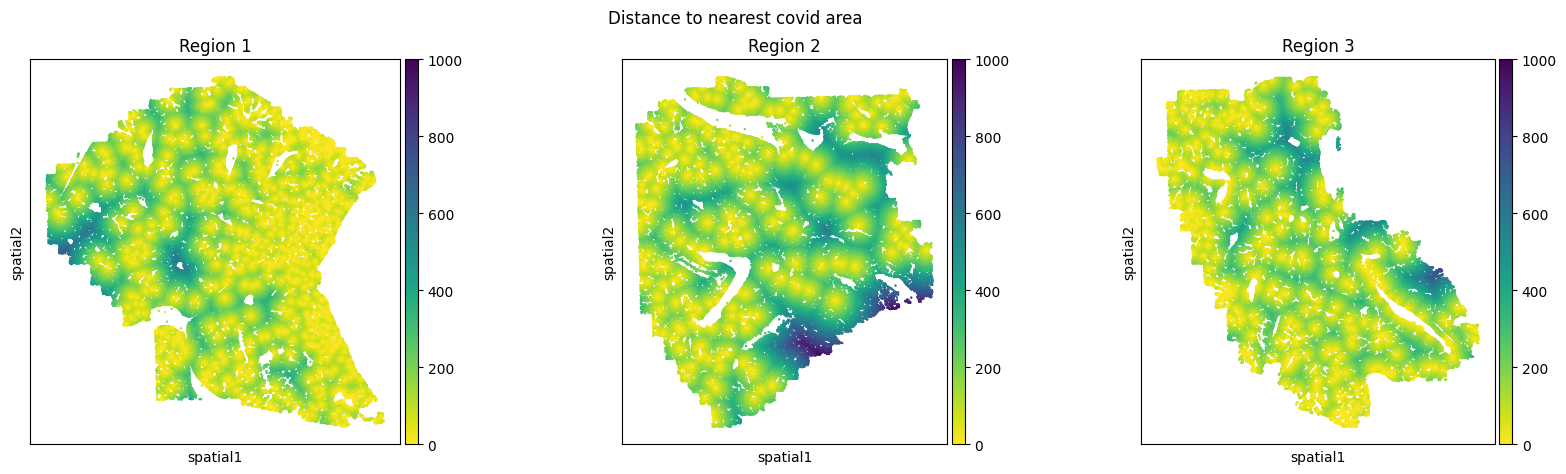

In [ ]:
import squidpy as sq
#plot cells with distance to nearest covid area
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distance to nearest covid area')
#add distance to nearest covid area to adata object at
#sc.pl.scatter(adata_region_1_distance, x='center_x', y='center_y', ax=ax[0], show=False,title='Region 0',color=['distance_to_nearest_covid'])
cmap='viridis_r'
sq.pl.spatial_scatter(adata_region_1_distance,library_id="spatial",color=['distance_to_nearest_covid'],size=1,ax=ax[0],title='Region 1',shape=None,cmap=cmap,vmin=0,vmax=1000)
sq.pl.spatial_scatter(adata_region_2_distance,library_id="spatial",color=['distance_to_nearest_covid'],size=1,ax=ax[1],title='Region 2',shape=None,cmap=cmap,vmin=0,vmax=1000)
sq.pl.spatial_scatter(adata_region_3_distance,library_id="spatial",color=['distance_to_nearest_covid'],size=1,ax=ax[2],title='Region 3',shape=None,cmap=cmap,vmin=0,vmax=1000)

fig.savefig(os.path.join(save_dir, "distance_covid_overlay_inverted.png"), dpi=300, bbox_inches='tight')

Convert geopandas dataframe to wkt format (Well known text) to maintain compatibility with saving as anndata h5ad. 

To read it back as shapely polygons, use shapely `wkt.loads`

In [18]:

#convert geopandas dataframe to wkt format and then convert to pandas dataframe. Otherwise cannot save as h5ad
def convert_to_wkt(adata_orig):
    """
    Convert a GeoDataFrame to WKT format.
    """
    adata = adata_orig.copy()
    gdf_covid = adata.uns['covid_area']
    gdf_tissue = adata.uns['tissue_analysis_area']

    gdf_covid = gdf_covid.to_wkt()#['geometry'].apply(lambda geom: geom.wkt)
    gdf_tissue = gdf_tissue.to_wkt()#['geometry'].apply(lambda geom: geom.wkt)

    #convert to regular pandas dataframe

    #df_covid = pd.DataFrame(gdf_covid)
    #df_tissue = pd.DataFrame(gdf_tissue)

    adata.uns['covid_area'] = gdf_covid
    adata.uns['tissue_analysis_area'] = gdf_tissue

    return adata

adata_region_0_wkt = convert_to_wkt(adata_region_0)
adata_region_1_wkt = convert_to_wkt(adata_region_1_distance)
adata_region_2_wkt = convert_to_wkt(adata_region_2_distance)
adata_region_3_wkt = convert_to_wkt(adata_region_3_distance)
#adata_region_1.uns['covid_area'] = convert_to_wkt(adata_region_1.uns['covid_area'])
#adata_region_1.uns['tissue_analysis_area'] = convert_to_wkt(adata_region_1.uns['tissue_analysis_area'])



In [20]:
adata_region_1_wkt

AnnData object with n_obs × n_vars = 95041 × 315
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'distance_to_nearest_covid'
    var: 'gene_names'
    uns: 'covid_area', 'tissue_analysis_area'
    obsm: 'spatial'

In [21]:
#save the anndata objects
save_dir = os.path.join(parent_dir, "anndata_files")
os.makedirs(save_dir, exist_ok=True)
adata_region_0_wkt.write_h5ad(os.path.join(save_dir, "adata_region_0.h5ad"))
adata_region_1_wkt.write_h5ad(os.path.join(save_dir, "adata_region_1.h5ad"))
adata_region_2_wkt.write_h5ad(os.path.join(save_dir, "adata_region_2.h5ad"))
adata_region_3_wkt.write_h5ad(os.path.join(save_dir, "adata_region_3.h5ad"))



These anndata objects were then used for downstream analysis and creating final MERSCOPE processed objects